In [72]:
#!unzip /content/Data_Assignment4.zip -d /content/dataset/

In [73]:
#!unzip /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/tA.zip -d /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA/

In [74]:
#!unzip /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/ni.zip -d /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA/

In [75]:
#!unzip /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/ka.zip -d /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA/

In [76]:
#!unzip /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/bhA.zip -d /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA/

In [77]:
#!unzip /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATA/ba.zip -d /content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA/

In [78]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import numpy as np
from torch.utils.data import DataLoader, TensorDataset,Dataset

import random
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import clear_output

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [81]:
def load_data(directory, labels, mode='train', reshape=True):
    dataset = []
    for label_name in labels:
        count = 0
        folder_path = os.path.join(directory, label_name, mode)
        label_index = labels[label_name]

        for file in os.listdir(folder_path):
            if count == 0:
                print(file)
            data = np.loadtxt(os.path.join(folder_path, file))  # Load data from file

            if reshape:
                data = data[1:].reshape(-1, 2)  # Reshape if necessary

            # Normalize the data
            data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
            tensor_data = torch.from_numpy(data)
            dataset.append((tensor_data.to(torch.float32), label_index))
            count += 1

    np.random.shuffle(dataset)  # Shuffle the dataset
    return dataset

class CustomSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index][0], dtype=torch.float32)
        label = torch.tensor(self.sequences[index][1], dtype=torch.long)
        return sequence, label

def custom_collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence([s for s in sequences], batch_first=True)
    return padded_sequences, torch.tensor(labels, dtype=torch.long)

def create_data_loader(directory, labels, batch_size, mode='train', reshape=True):
    data = load_data(directory, labels, mode, reshape)
    dataset = CustomSequenceDataset(data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    return data_loader

# Define label mappings
label_names = {'ba': 0, 'bhA': 1, 'ka': 2, 'ni': 3, 'tA': 4}

# Create data loaders
train_loader = create_data_loader('/content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA', label_names, batch_size=64, mode='Train', reshape=False)
test_loader = create_data_loader('/content/dataset/Data_Assignment4/Data:Assignment4/CV_DATAA', label_names, batch_size=64, mode='Test', reshape=False)

print(f'Train Loader: {len(train_loader.dataset)} samples')
print(f'Test Loader: {len(test_loader.dataset)} samples')


05_ba_32_8.mfcc
19_bhA_83_10.mfcc
18_ka_98_15.mfcc
18_ni_66_15.mfcc
10_tA_8_4.mfcc
12_ba_124_8.mfcc
04_bhA_134_10.mfcc
02_ka_26_10.mfcc
03_ni_170_11.mfcc
18_tA_113_10.mfcc
Train Loader: 1464 samples
Test Loader: 366 samples


# Model

In [82]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_dim)

    def forward(self, sequences):
        # Initialize hidden state (num_layers, batch_size, hidden_units)
        sequences = sequences.to(device)
        h0 = torch.zeros(self.num_layers, sequences.size(0), self.hidden_units).to(device)

        # Forward pass through RNN
        out, _ = self.rnn(sequences, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, sequences):
        output = self.forward(sequences)
        return torch.argmax(output, dim=1)

    def compute_accuracy(self, dataset):
        total_samples = 0
        correct_predictions = 0

        for sequences, labels in dataset:
            labels = labels.to(device)
            total_samples += len(sequences)
            correct_predictions += (labels == self.predict(sequences)).sum().item()

        return correct_predictions / total_samples


In [83]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_dim)

    def forward(self, sequences):
        # Forward pass through LSTM layer
        sequences = sequences.to(device)
        lstm_out, _ = self.lstm(sequences)
        # We take the output of the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out

    def predict(self, sequences):
        output = self.forward(sequences)
        return torch.argmax(output, dim=1)

    def compute_accuracy(self, dataset):
        total_samples = 0
        correct_predictions = 0

        for sequences, labels in dataset:
            labels = labels.to(device)
            total_samples += len(sequences)
            correct_predictions += (labels == self.predict(sequences)).sum().item()

        return correct_predictions / total_samples


In [84]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_dim)

    def forward(self, sequences):
        # Forward pass through GRU layer
        sequences = sequences.to(device)
        gru_out, _ = self.gru(sequences)
        # We take the output of the last time step
        out = self.fc(gru_out[:, -1, :])
        return out

    def predict(self, sequences):
        output = self.forward(sequences)
        return torch.argmax(output, dim=1)

    def compute_accuracy(self, dataset):
        total_samples = 0
        correct_predictions = 0

        for sequences, labels in dataset:
            labels = labels.to(device)
            total_samples += len(sequences)
            correct_predictions += (labels == self.predict(sequences)).sum().item()

        return correct_predictions / total_samples


# Training

In [85]:
def train_model(data_loader, neural_network, total_epochs, loss_function, optimizer, validation_data):
    training_history = {
        'loss_history': [],
        'validation_accuracy': []
    }

    for epoch in range(total_epochs):
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = neural_network(inputs)

            # Calculate loss
            loss_value = loss_function(predictions, targets)

            # Backward pass and weight update
            loss_value.backward()
            optimizer.step()

        # Calculate validation accuracy
        validation_accuracy = neural_network.compute_accuracy(validation_data)
        training_history['loss_history'].append(loss_value.item())
        training_history['validation_accuracy'].append(validation_accuracy)

        # Print training progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{total_epochs}], Loss: {loss_value.item():.4f}, Acc: {validation_accuracy:.4f}')

    return training_history

def average_values(dict_list):
    count = 0
    for dictionary in dict_list:
        if count == 0:
            aggregated_values = np.array(list(dictionary.values()))
        else:
            aggregated_values += np.array(list(dictionary.values()))
        count += 1
    return aggregated_values / count

def execute_model(input_dim, hidden_dim, output_dim, layers, model_class, data_loader, num_epochs):
    neural_net = model_class(input_dim, hidden_dim, output_dim, layers)
    neural_net = neural_net.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(neural_net.parameters())
    history = train_model(data_loader, neural_net, num_epochs, loss_function, optimizer, data_loader)
    return neural_net, history


In [86]:
model_types = {'GRU': GRUModel, 'LSTM': LSTMModel, 'RNN': SimpleRNN}
num_layers = [1, 2]
hidden_units = [16, 32]

q2_results_df = pd.DataFrame(columns=['model', 'type', 'layers', 'hidden', 'test_accuracy', 'final_loss', 'training_history', 'training_accuracy'])

for num_layers in num_layers:
    for hidden in hidden_units:
        for model_key in model_types:
            print(f"Layers: {num_layers}, Nodes: {hidden}, Model: {model_key}")

            trained_model, training_history = execute_model(39, hidden, 5, num_layers, model_types[model_key], train_loader, 100)

            q2_results_df.loc[len(q2_results_df)] = [
                trained_model,
                model_key,
                num_layers,
                hidden,
                trained_model.compute_accuracy(test_loader),
                training_history['loss_history'][-1],
                training_history,
                training_history['validation_accuracy'][-1]
            ]

            clear_output()


In [87]:
grouped_results = q2_results_df.groupby(['type', 'layers', 'hidden'])['training_history'].agg(average_values).reset_index()
grouped_results['loss_history'] = grouped_results['training_history'].apply(lambda x: x[0])
grouped_results['accuracy_history'] = grouped_results['training_history'].apply(lambda x: x[1])
grouped_results.drop('training_history', axis=1, inplace=True)
exploded_results = grouped_results.explode(['loss_history', 'accuracy_history'])
exploded_results['epoch'] = exploded_results.groupby(['type', 'layers', 'hidden'])['loss_history'].cumcount() + 1
exploded_results

,type,layers,hidden,loss_history,accuracy_history,epoch
0,GRU,1,16,1.579686,0.270492,1
0,GRU,1,16,1.580472,0.271858,2
0,GRU,1,16,1.602645,0.273907,3
0,GRU,1,16,1.524709,0.284153,4
0,GRU,1,16,1.55716,0.289617,5
...,...,...,...,...,...,...
11,RNN,2,32,1.342045,0.362705,96
11,RNN,2,32,1.402018,0.35929,97
11,RNN,2,32,1.481071,0.359973,98
11,RNN,2,32,1.489213,0.356557,99


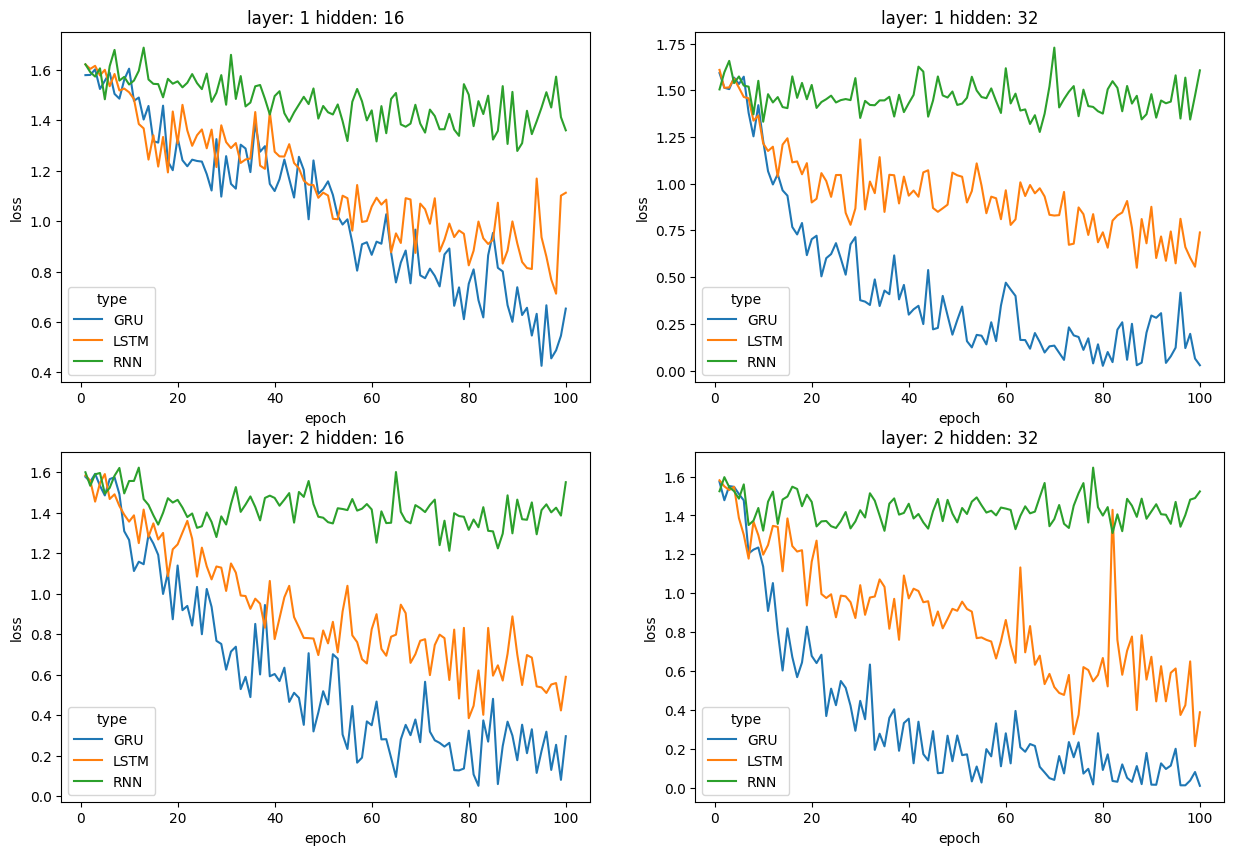

In [88]:
layer_counts = [1, 2]
hidden_units = [16, 32]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for l in layer_counts:
    for h in hidden_units:
        ax = axes[l - 1][h // 16 - 1]
        filtered_data = exploded_results[(exploded_results['layers'] == l) & (exploded_results['hidden'] == h)]
        sns.lineplot(filtered_data, x='epoch', y='loss_history', hue='type', ax=ax)
        ax.set_title(f'layer: {l} hidden: {h}')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')

In [89]:
best_results = q2_results_df[q2_results_df['test_accuracy'] == q2_results_df['test_accuracy'].max()][['model', 'layers', 'hidden', 'training_accuracy', 'test_accuracy']]
best_model = best_results['model'].iloc[0]
best_results

,model,layers,hidden,training_accuracy,test_accuracy
3,"GRUModel(\n (gru): GRU(39, 32, batch_first=Tr...",1,32,0.982923,0.822404


In [90]:
predictions = []
true_labels = []
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)
    predictions.append(best_model.predict(data).clone().detach().tolist())
    true_labels.append(labels.tolist())

predictions = [item for batch in predictions for item in batch]
true_labels = [item for batch in true_labels for item in batch]
predictions = np.array(predictions).reshape(-1)
true_labels = np.array(true_labels).reshape(-1)


<ipython-input-81-0d3be4fd21e0>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.sequences[index][0], dtype=torch.float32)


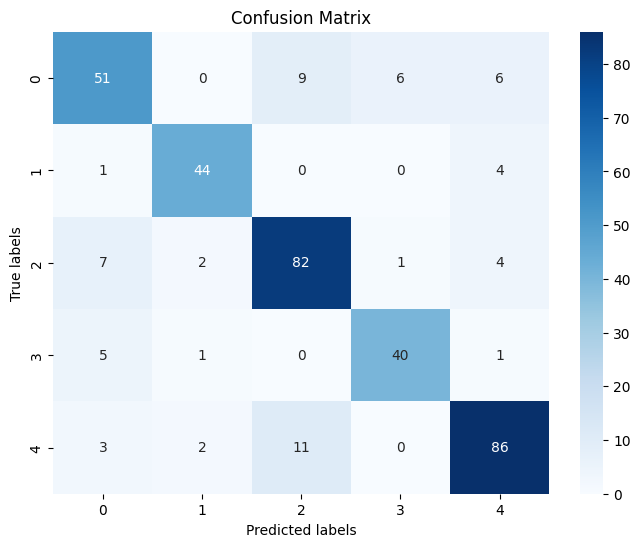

In [91]:
confusion_mat = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()